<a href="https://colab.research.google.com/github/SarmSKunatham/Pytorch/blob/main/Training_Deep_Neural_Network_on_GPU_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import 

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
# Download dataset
dataset = MNIST(root="data/", download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
len(dataset)

60000

Image shape: torch.Size([1, 28, 28])


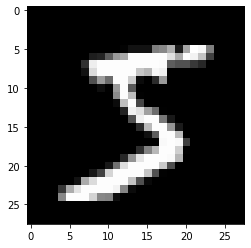

In [15]:
image, label = dataset[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(0), cmap="gray")


In [17]:
# Split train and test set
val_percent = 0.1
val_size = int(len(dataset) * val_percent)
train_size = len(dataset) - val_size
# split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(54000, 6000)

In [20]:
# Data Loader
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=True)

Image Shape: torch.Size([128, 1, 28, 28])
Label Shape: torch.Size([128])


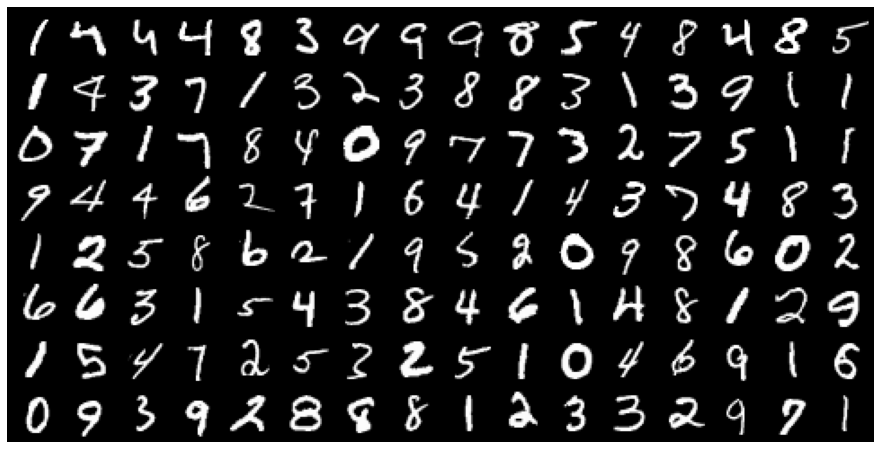

In [23]:
# Visualize one batch
for xb, yb in train_dl:
  print(f"Image Shape: {xb.shape}")
  print(f"Label Shape: {yb.shape}")
  plt.figure(figsize=(16,8))
  plt.axis("off")
  plt.imshow(make_grid(xb, nrow=16).permute(1,2,0))
  break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a _hidden layer_ and an _output layer_. Additionally, we'll use an _activation function_ between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [24]:
for images, labels in train_dl:
  print(f"Images shape: {images.shape}")
  inputs = images.reshape(-1, 784)
  print(f"Inputs shape: {inputs.shape}")
  break

Images shape: torch.Size([128, 1, 28, 28])
Inputs shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our _hidden_ layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the _learning capacity_ of the model.

In [25]:
input_size = inputs.shape[-1]
hidden_size = 32

In [26]:
layer1 = nn.Linear(input_size, 32)

In [27]:
inputs.shape

torch.Size([128, 784])

In [28]:
layer1_output = layer1(inputs)
print(f"Layer1 output shape: {layer1_output.shape}")

Layer1 output shape: torch.Size([128, 32])


The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias. We can verify this using `torch.allclose`. For a more detailed explanation, review the tutorial on [linear regression](https://jovian.ai/aakashns/02-linear-regression).

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [29]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values were replaced with 0.

In [30]:
relu_outputs = F.relu(layer1_output)
print('min(layer1_outputs): ', torch.min(layer1_output).item())
print("min(relu_outputs: ", torch.min(relu_outputs).item())

min(layer1_outputs):  -0.7372353672981262
min(relu_outputs:  0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [31]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [32]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [33]:
inputs.shape

torch.Size([128, 784])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [34]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3080, grad_fn=<NllLossBackward0>)

Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A _deep neural network_ is simply a neural network with one or more hidden layers. In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can _learn_ rich and complex non-linear relationships between inputs and targets. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [43]:
class MnistModel(nn.Module):
  '''Feed forward neural network with 1 hidden layer'''
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    # Flatten the iamge tensor
    xb = xb.view(xb.size(0), -1)
    # Get intermediate outputs using hidden layer
    out = self.linear1(xb)
    # Apply activation fn
    out = F.relu(out)
    # Get prediction using ouput layer
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images) # Generate prediciton
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch 
    # Generate prediction
    out = self(images)
    # Calculate loss
    loss = F.cross_entropy(out, labels)
    # Calculate accuracy
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    # Combine losses
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    # Combine accuracies
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


In [36]:
# Define accuracy function
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [41]:
input_size = 784
hidden_size = 32
num_classes = 10

In [44]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [45]:
# Look at the models parameter
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [46]:
torch.cuda.is_available()

True

In [53]:
def get_default_device():
  return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [54]:
device = get_default_device()

This uses function recursion (look it up and think about the film Inception!). It is a way to "go one level down" programmatically, when needed.

Example 1: Imagine "data" is a simple tensor. The if statement is False, so you simply do tensor.to(device).

Example 2: Now imagine "data" is a list of tensors. The tensor.to(device) method applies only for tensors, not lists of tensors. So the trick used here goes like this: "data" is a list, so the if statement is True, so you "go one level down" and re-apply the whole function to_device to each individual tensor in the list. Now each element is a tensor, so the if statement is False, so you move each to "device".

p.s. This can go on indefinitely, e.g. imagine having collections of collections of collections etc. Eventually, the function will be applied to the single Tensors stored in those collections.

In [55]:
def to_device(data, device):
  '''Move tensor to chosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [56]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [57]:
class DeviceDataLoader():
  '''Wrap a dataloader to move data to a device'''
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to device'''
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.dl)

The `yield` keyword in Python is used to create a generator function that can be used within a `for` loop, as illustrated below.

In [58]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [59]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

Tensors moved to the GPU have a `device` property which includes that word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [60]:
for xb, yb in val_loader:
  print(f"xb.device: {xb.device}")
  print(xb)
  print(f"yb: {yb}")
  break

xb.device: cuda:0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0.

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [73]:
def evaluate(model, val_loader):
  '''Evaluate the model's performance on the validation set'''
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  '''Train the model using gradient descent'''
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation Phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  
  return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [74]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [75]:
# Initial
h0 = [evaluate(model, val_loader)]
h0

[{'val_acc': 0.11407674849033356, 'val_loss': 2.3077869415283203}]

In [76]:
h0 += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2224, val_acc: 0.9351
Epoch [1], val_loss: 0.1603, val_acc: 0.9529
Epoch [2], val_loss: 0.1478, val_acc: 0.9559
Epoch [3], val_loss: 0.1218, val_acc: 0.9632
Epoch [4], val_loss: 0.1165, val_acc: 0.9635


In [77]:
h0 += fit(10, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1048, val_acc: 0.9675
Epoch [1], val_loss: 0.1007, val_acc: 0.9687
Epoch [2], val_loss: 0.1001, val_acc: 0.9692
Epoch [3], val_loss: 0.1024, val_acc: 0.9680
Epoch [4], val_loss: 0.1009, val_acc: 0.9672
Epoch [5], val_loss: 0.0992, val_acc: 0.9682
Epoch [6], val_loss: 0.1000, val_acc: 0.9685
Epoch [7], val_loss: 0.0987, val_acc: 0.9697
Epoch [8], val_loss: 0.0986, val_acc: 0.9684
Epoch [9], val_loss: 0.1036, val_acc: 0.9672


Text(0.5, 1.0, 'Loss vs No. of epochs')

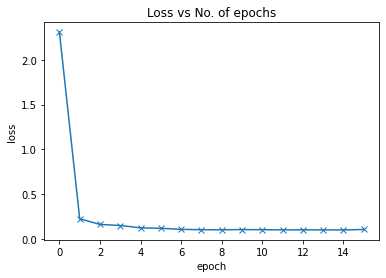

In [82]:
losses = [x['val_loss'] for x in h0]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No. of epochs')

Text(0.5, 1.0, 'Accuracy vs No. of epoch')

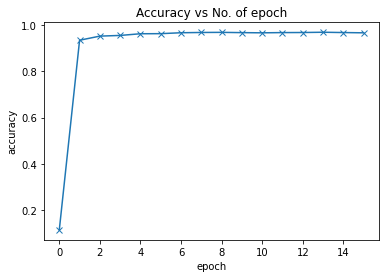

In [83]:
acc = [x['val_acc'] for x in h0]
plt.plot(acc, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epoch')

# Testing with individual images

In [84]:
test_dataset = MNIST(root="data/", train=False, transform=ToTensor())

In [88]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: 7 Predicted:  7


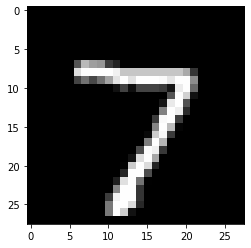

In [89]:
img, label = test_dataset[0]
pred = predict_image(img, model)
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted: ', pred)

In [90]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.972949206829071, 'val_loss': 0.09462259709835052}

## Summary and Further Reading

Here is a summary of the topics covered in this tutorial:

* We created a neural network with one hidden layer to improve upon the logistic regression model from the previous tutorial. We also used the ReLU activation function to introduce non-linearity into the model, allowing it to learn more complex relationships between the inputs (pixel densities) and outputs (class probabilities).

* We defined some utilities like `get_default_device`, `to_device` and `DeviceDataLoader` to leverage a GPU if available, by moving the input data and model parameters to the appropriate device.

* We were able to use the exact same training loop: the `fit` function we had define earlier to train out model and evaluate it using the validation dataset.

There's a lot of scope to experiment here, and I encourage you to use the interactive nature of Jupyter to play around with the various parameters. Here are a few ideas:

* Try changing the size of the hidden layer, or add more hidden layers and see if you can achieve a higher accuracy.

* Try changing the batch size and learning rate to see if you can achieve the same accuracy in fewer epochs.

* Compare the training times on a CPU vs. GPU. Do you see a significant difference. How does it vary with the size of the dataset and the size of the model (no. of weights and parameters)?

* Try building a model for a different dataset, such as the [CIFAR10 or CIFAR100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html).

Here are some references for further reading:

* [A visual proof that neural networks can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html), also known as the Universal Approximation Theorem.

* [But what *is* a neural network?](https://www.youtube.com/watch?v=aircAruvnKk) - A visual and intuitive introduction to what neural networks are and what the intermediate layers represent

* [Stanford CS229 Lecture notes on Backpropagation](http://cs229.stanford.edu/notes/cs229-notes-backprop.pdf) - for a more mathematical treatment of how gradients are calculated and weights are updated for neural networks with multiple layers.


You are now ready to move on to the next tutorial: [Image Classification using Convolutional Neural Networks](https://jovian.ai/aakashns/05-cifar10-cnn).